In [1]:
import keras
import PIL.ImageFilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from keras.preprocessing.image import load_img, img_to_array
import multiprocessing as mp 
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from huggingface_hub import from_pretrained_keras
from PIL import ImageFilter, ImageEnhance
import seaborn as sns
import json
import shap



2024-01-26 04:00:42.405772: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-26 04:00:42.408304: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 04:00:42.448165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 04:00:42.448215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 04:00:42.449233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def load_data(files, start=0, end=10, augment_fn = None): #same accuracy for 90,180, 270 rotation
    X = []
    y = []
    for f in files[start:end]:
        img = load_img(f, target_size=(50, 50))
        print(f'process file {f}')
        if augment_fn is not None:
            sample = augment_fn(img)
        else:    
            sample = tf.convert_to_tensor(img)
        X.append(sample)
        y.append(f[-5])
    return np.array(files[start:end]), np.stack(X), np.array(y, dtype=float)

In [3]:
data = pd.read_csv('all_outputs.csv')

false_predictions = data.loc[(data["pred_y"] > 0.5) != data["true_y"]]
false_positives = false_predictions.loc[false_predictions["pred_y"] > 0.5]
false_negatives = false_predictions.loc[false_predictions["pred_y"] < 0.5]
false_positive_files = false_positives['# file']
false_negative_files = false_negatives['# file']

n = 2
false_negatives_sample = np.random.randint(0, len(false_negative_files), n)
false_positives_sample = np.random.randint(0, len(false_positive_files), n)
false_negative_sample_files = false_negative_files.iloc[false_negatives_sample]
false_positive_sample_files = false_positive_files.iloc[false_positives_sample]
sample_files = false_positive_sample_files._append(false_negative_sample_files)
sample_true_y = np.ndarray([1, 1, 0, 0])

_, x, _ = load_data(sample_files, start=0, end=4)

process file ../data/9083/0/9083_idx5_x951_y301_class0.png
process file ../data/8950/0/8950_idx5_x1701_y1001_class0.png
process file ../data/13616/1/13616_idx5_x2551_y1451_class1.png
process file ../data/16533/1/16533_idx5_x1301_y1501_class1.png


In [4]:
bc_model = keras.models.load_model("../models/CanDetect.keras")
masker = shap.maskers.Image("inpaint_telea", x[0].shape)
explainer = shap.Explainer(bc_model, masker)

In [5]:
shap_values = [0 for _ in range(4)]
shap_values[0] = explainer(x[0:1], max_evals=500, batch_size=50)
shap_values[1] = explainer(x[1:2], max_evals=500, batch_size=50)
shap_values[2] = explainer(x[2:3], max_evals=500, batch_size=50)
shap_values[3] = explainer(x[3:4], max_evals=500, batch_size=50)

  0%|          | 0/498 [00:00<?, ?it/s]

False positive


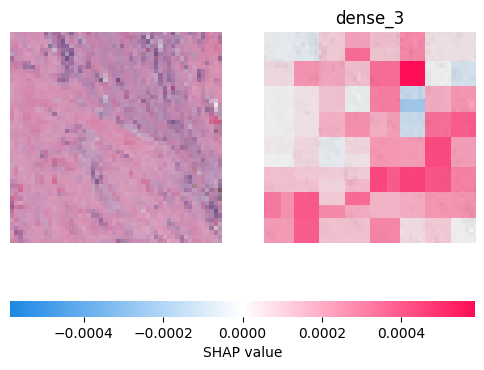

False positive


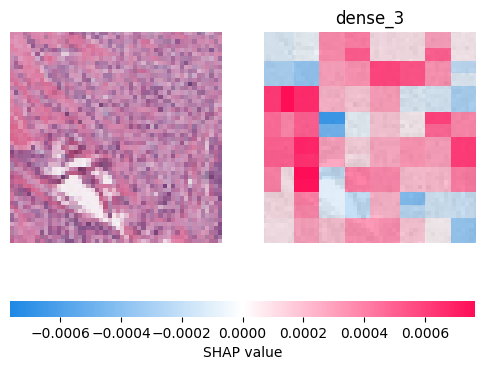

False negative


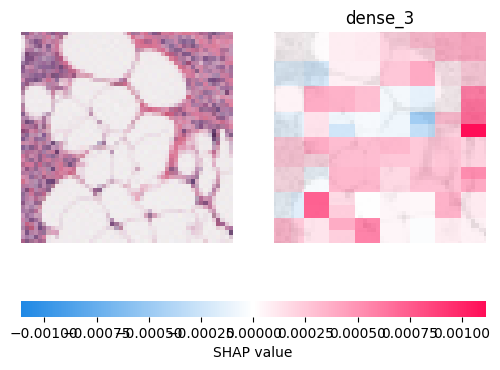

False negative


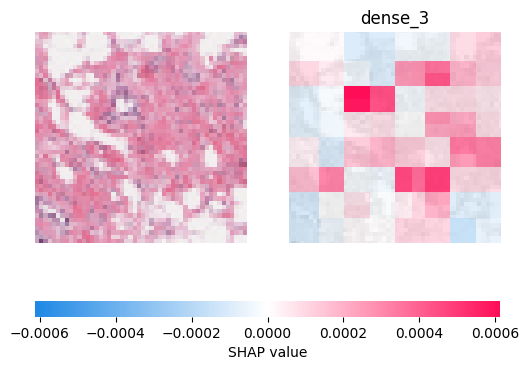

In [6]:
for i in range(4):
    if i < 2:
        print("False positive")
    else:
        print("False negative")
    shap.image_plot(shap_values[i])

  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 97ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
sample 680, prediction = [[0.09084854]]


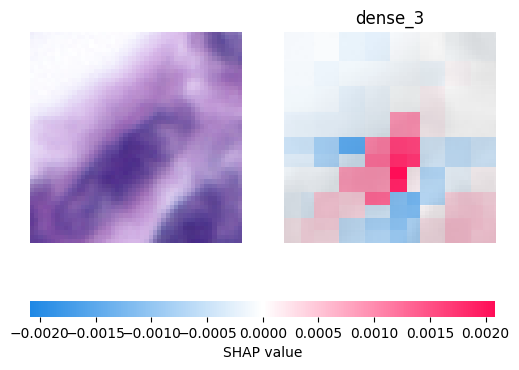

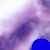

sample 187, prediction = [[0.02003565]]


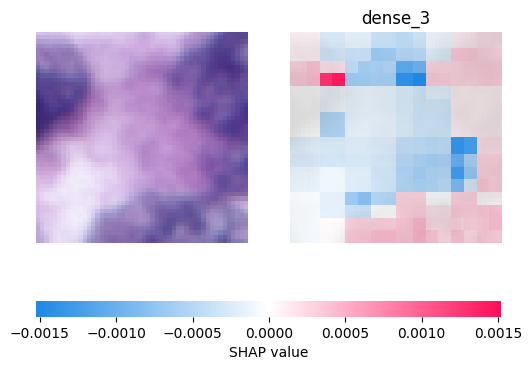

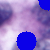

sample 750, prediction = [[0.00526587]]


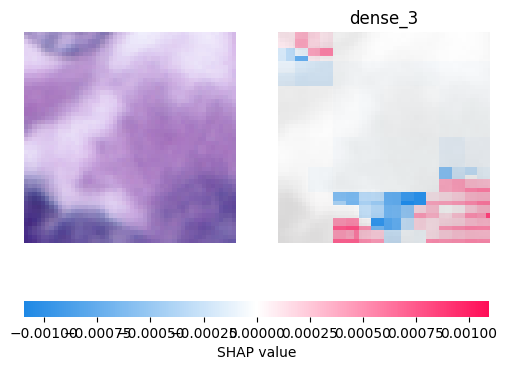

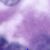

sample 160, prediction = [[0.0331657]]


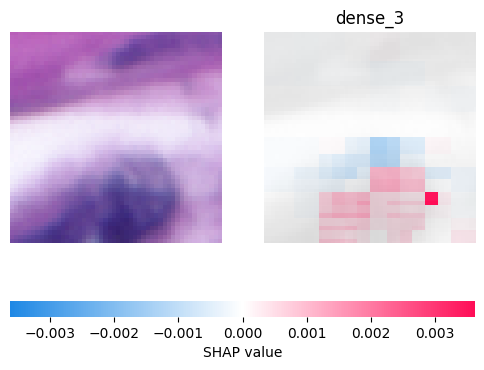

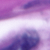

sample 412, prediction = [[0.00037743]]


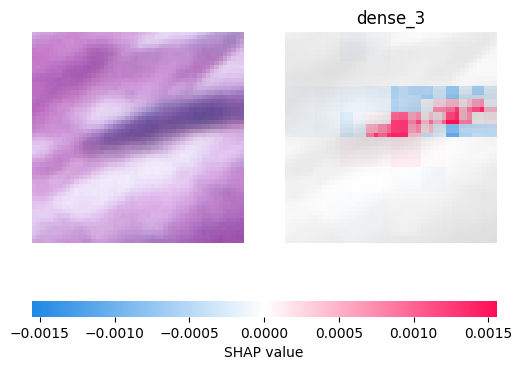

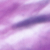

sample 521, prediction = [[0.32320434]]


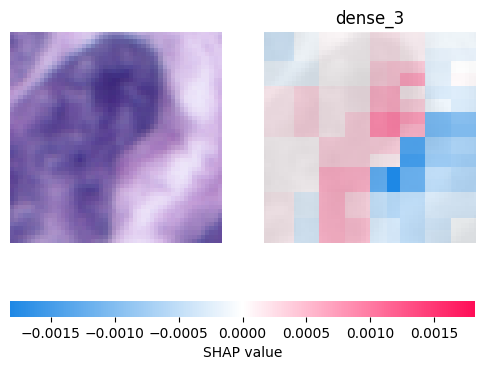

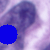

sample 946, prediction = [[0.05506247]]


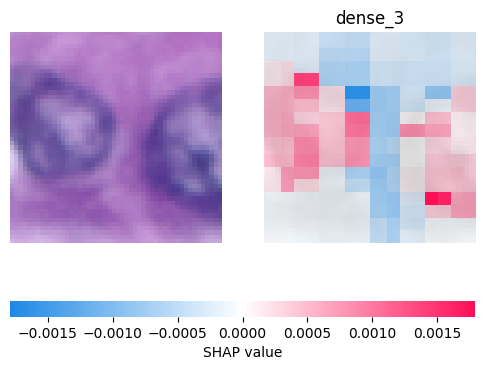

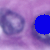

sample 951, prediction = [[0.08840731]]


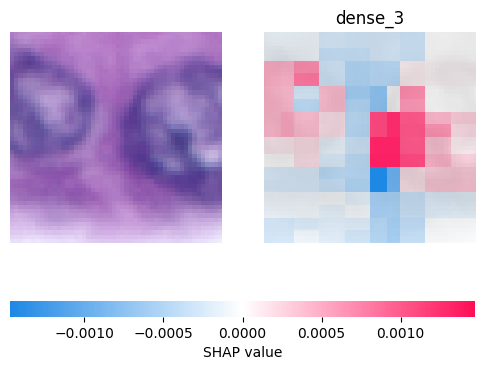

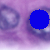

sample 250, prediction = [[0.13694595]]


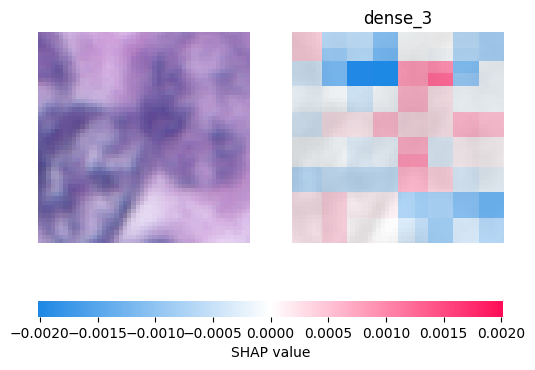

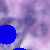

sample 232, prediction = [[0.07000421]]


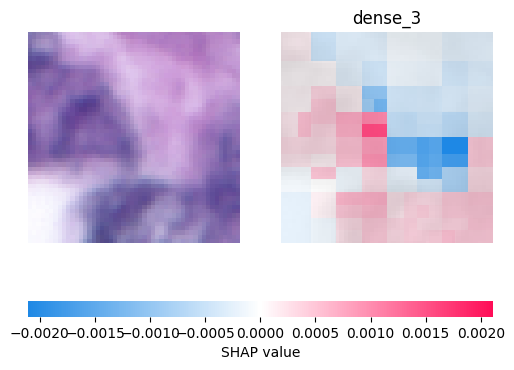

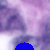

sample 251, prediction = [[0.13995807]]


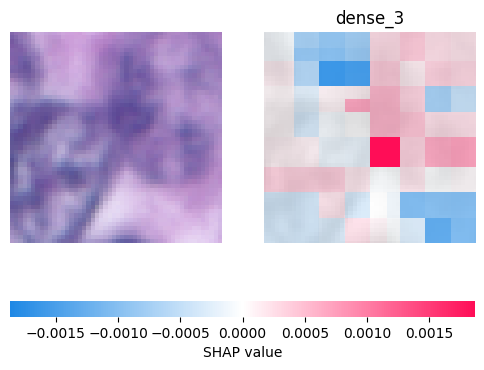

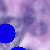

sample 811, prediction = [[0.00289412]]


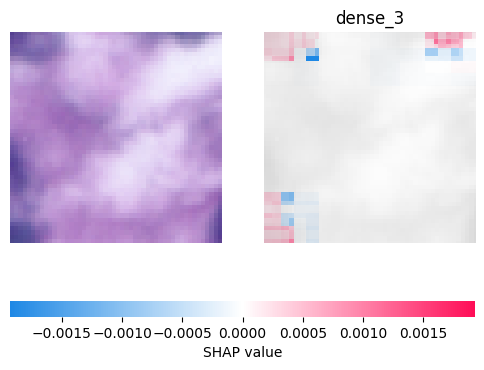

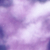

sample 54, prediction = [[0.63297516]]


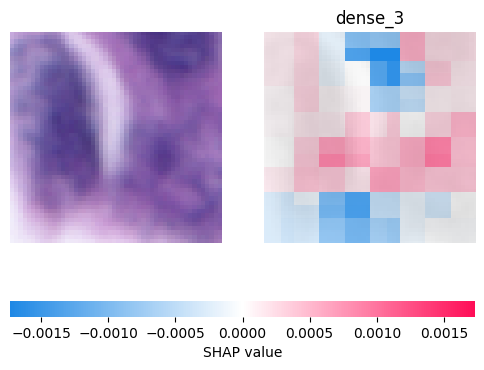

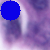

sample 617, prediction = [[0.37780222]]


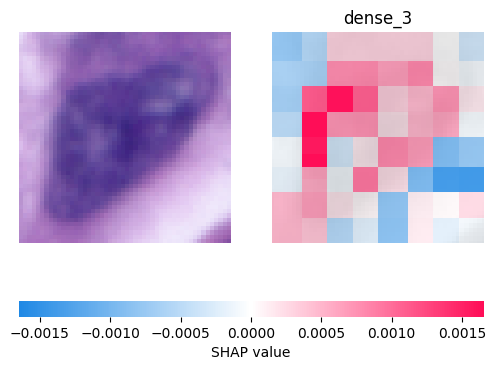

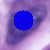

sample 771, prediction = [[0.35325897]]


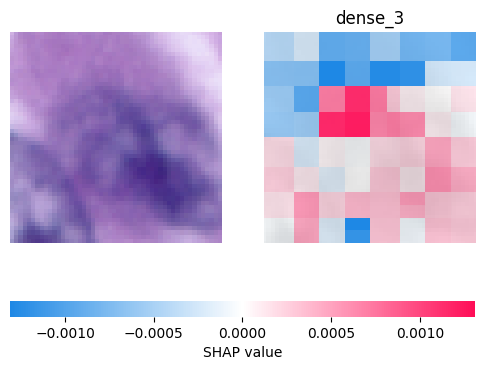

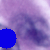

sample 985, prediction = [[0.00113292]]


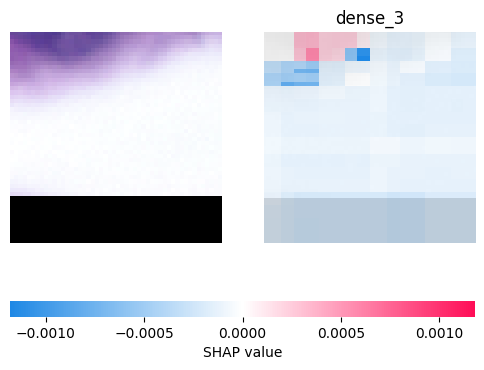

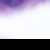

sample 736, prediction = [[0.01062828]]


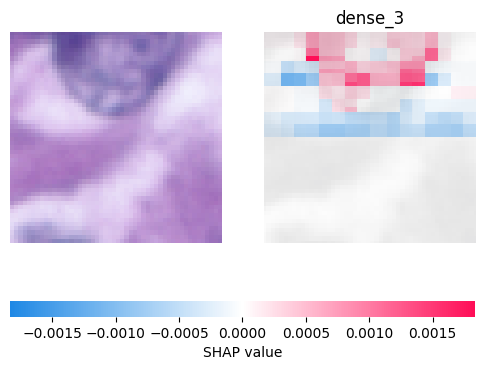

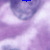

sample 191, prediction = [[0.04532759]]


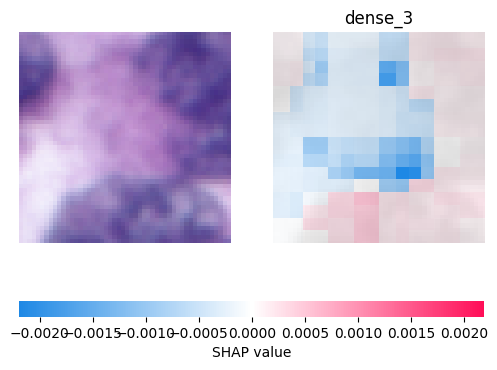

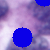

sample 745, prediction = [[0.00349477]]


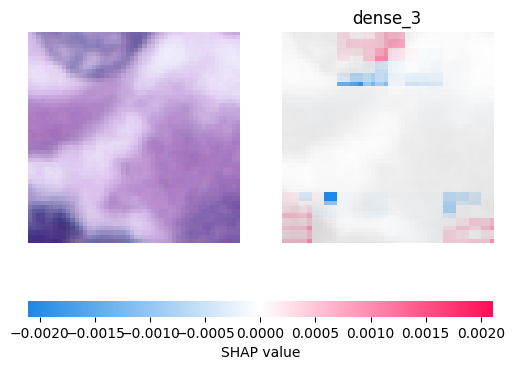

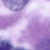

sample 517, prediction = [[0.4159513]]


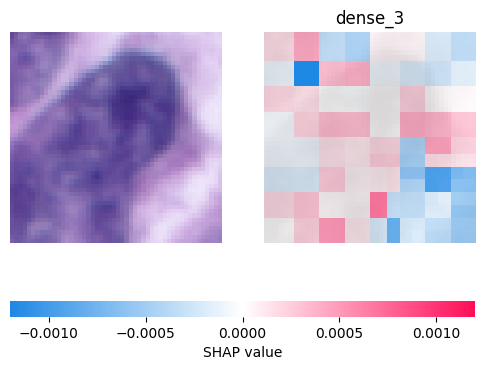

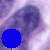

In [7]:
from PIL import Image
#image = Image.open('/home/monika/Moje/ML-sem-III/eml2023/project/original_data_set/BreCaHAD/images/Case_1-01.tif')
image = Image.open('/home/mdrzewiecki/mim/BreastCancerAnalysis/data/images/Case_1-01.tif')
#ground_truth = Image.open('/home/monika/Moje/ML-sem-III/eml2023/project/original_data_set/BreCaHAD/groundTruth_display/Case_1-01.png')
ground_truth = Image.open('/home/mdrzewiecki/mim/BreastCancerAnalysis/data/groundTruth_display/Case_1-01.png')

selected_ids = np.random.randint(0, 1000, 20)
shap_values = dict()
ground_truth_images = dict()
predictions = dict()

for i in selected_ids:
    image_part = image.crop((i, i, i + 50, i + 50))
    ground_truth_part = ground_truth.crop((i, i, i + 50, i + 50))
    ground_truth_images[i] = (np.array(ground_truth_part))
    image_part = tf.convert_to_tensor(image_part)
    image_part = image_part[None, :, :, :]
    image_part = image_part.numpy()
    shap_values[i] = explainer(image_part, max_evals=500, batch_size=50)
    predictions[i] = bc_model.predict(image_part)

for i in selected_ids:
    print(f"sample {i}, prediction = {predictions[i]}")
    shap.image_plot(shap_values[i])
    display(Image.fromarray(ground_truth_images[i]))
    print("========================================================")